In [1]:
import numpy as np
import xarray as xr
import gsw
from datetime import datetime
from matplotlib import pyplot as plt
from tqdm import tqdm

***

Define constants and parameters

In [34]:
# Define constants and parameters
cpsw = 3.996e3  # Heat capacity of seawater [W/kg*degC]
nreg = 15       # Number of regions
dinc = 0.1      # Sigma bin size
ndinc = 101     # Number of sigma bins
sigma0 = 19     # Sigma start

# Create sigma classes
dclass = np.append(np.arange(ndinc) * dinc + sigma0, 1e32)

# Results path
resultspath = '../../results/bc5_ne120_t12_v0.1/'

# Fluxes due to ice formation (not available from POP results)
qflux, qflux_s = 0, 0

# Build transformation dict (sigma bins x regions)
names = ['heat', 'salt', 'heat_ice', 'salt_ice']
tr = {name: {hs: np.zeros((ndinc, nreg)) for hs in ('nh', 'sh')} for name in names}

Load, flatten and mask results

In [35]:
# Loop through years and months
for year in range(1996, 2001):
    for month in tqdm(range(1, 13), desc=f'Loading {year}...'):
        
        # Open results file and extract variables
        datestr = datetime(year, month, 1).strftime('%Y-%m')
        filename = f'bc5_ne120_t12_v0.1_00002.pop.h.{datestr}.nc'
        with xr.open_dataset(resultspath + filename) as ds:

            # Prepare masks
            landmask = ds['KMT'].values.flatten()
            landmask = landmask > 0

            # Load coordinates
            names = ['TLONG', 'TLAT', 'TAREA', 'REGION_MASK']
            lon, lat, area, regionmask = [ds[name].values.flatten()[landmask] for name in names]
            regionmask = abs(regionmask)      # [1, 14]
            lon = lon - 180                   # [-180, 180]
            area = area * 1e-4                # m2
            z0 = ds['z_t'].values[0] * 1e-2   # m

            # Load 2d variables
            names = ['SHF', 'SFWF', 'MELTH_F', 'MELT_F', 'SALT_F']
            shf, sfwf, melth_f, melt_f, salt_f = [ds[name][0, ...].values.flatten()[landmask] for name in names]

            # Load 3d variables at surface
            names = ['TEMP', 'SALT']
            sst, sss = [ds[name][0, 0, ...].values.flatten()[landmask] for name in names]
        
        # Density calculations
        ct = gsw.CT_from_pt(sss, sst)
        alpha = gsw.alpha(sss, ct, z0) * ct / sst
        beta = gsw.beta(sss, ct, z0)
        sigma = gsw.sigma0(sss, ct)

        # Buoyancy fluxes
        coefheat = alpha / cpsw
        coefsalt = -beta * sss / (1 - sss)
        bfluxes = {
            'heat': coefheat * (shf + qflux),
            'salt': coefsalt * (sfwf + qflux_s),
            'heat_ice': coefheat * (melth_f + qflux),
            'salt_ice': coefsalt * (salt_f + melt_f + qflux_s),
            'sigma': sigma,
            'area': area,
        }

        # Loop through hemispheres
        for hs, func in zip(['nh', 'sh'], ['greater', 'less_equal']):

            # Hemisphere mask
            hmask = getattr(np, func)(lat, 0)

            # Loop through regions
            for reg in range(1, nreg):

                # Mask region
                bf = {}
                rmask = (regionmask == reg) & hmask
                for name in bfluxes:
                    bf[name] = bfluxes[name][rmask]

                # Loop through density bins
                for i in range(ndinc):
                    dmask = (bf['sigma'] >= dclass[i]) & (bf['sigma'] < dclass[i+1])
                    for name in tr:
                        tr[name][hs][i, reg-1] = tr[name][hs][i, reg-1] + np.nansum(bf[name][dmask] * bf['area'][dmask])

Loading 2000...: 100%|██████████| 12/12 [00:27<00:00,  2.28s/it]


(-40.0, 30.0)

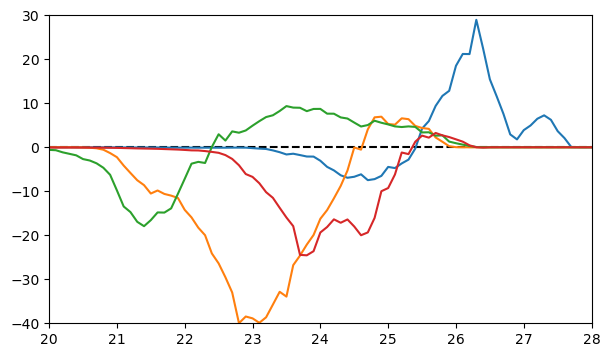

In [44]:
fig, ax = plt.subplots(figsize=(7, 4))
ax.plot([20, 28], [0, 0], 'k--')
for region in [0, 1, 2, 5]:
    ax.plot(dclass[:-1], -tr['heat']['sh'][:, region] / 60 / 0.1 * 1e-6)
ax.set_xlim([20, 28])
ax.set_ylim([-40, 30])